In [1]:
import csv
import subprocess
import shlex
import json

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import chisquare, kstest, norm
from IPython.display import display, Markdown

In [2]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

# Non-spatial Dispersal Coverage Test

In [3]:
def test_nonspatial_dispersal_coverage(
    algorithm, speciation=0.001, seed=42, size=100, sample=1.0
):
    # Configure the simulation
    config = "".join("""
    (
        speciation: {speciation},
        seed: {seed},
        sample: {sample},

        algorithm: {algorithm}(),

        scenario: NonSpatial(
            area: ({size}, {size}),
            deme: {size},
        ),

        reporters: [
            Plugin(
                library: "{target_directory}/release/deps/libnecsim_plugins_statistics.so",
                reporters: [
                    GlobalCoverage(output: "{output_file}"),
                ],
            ),
        ],
    )
    """.format(
        target_directory=target_directory, output_file="/dev/fd/2",
        algorithm=algorithm, speciation=speciation, seed=seed, sample=sample, size=size,
    ).split()).replace(",)", ")").replace(",]", "]")
    
    # Run the simulation
    locations_io = StringIO(subprocess.run(shlex.split(
        "cargo run --release --features rustcoalescence-algorithms-monolithic,"
        + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
    ), check=True, capture_output=True, text=True).stderr)
        
    
    # Read in the dispersal locations
    locations = []
    with locations_io:
        reader = csv.reader(locations_io)
        next(reader)

        for row in reader:
            locations.append((int(row[3]), int(row[4]), int(row[5])))
    locations = np.array(locations)
    
    # Calculate in the dispersal locations
    gof = chisquare(np.histogramdd(locations, bins=(
        range(0, size+1), range(0, size+1), range(0, size+1)
    ))[0].flatten())
    
    if gof.pvalue <= 0.05:
        display(Markdown(f"## <span style='color:red'><u>{algorithm}</u></span>"))
    elif gof.pvalue <= 0.1:
        display(Markdown(f"## <span style='color:orange'>*{algorithm}*</span>"))
    else:
        display(Markdown(f"## <span style='color:green'>{algorithm}</span>"))
    
    display(Markdown("#### Chi-squared test:\n* p-value: {gof.pvalue}\n* statistic: {gof.statistic}"))
    display(Markdown("#### Coverage Histograms:"))
    
    # Draw the 1d and 2d dispersal coverage histograms
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 10))
    
    ax1.set_title("Dispersal histogram x")
    ax1.set_xlabel("x")
    ax1.set_ylabel("pmf")
    ax1.hist(locations[:,0], bins=range(0, size+1), density=True)
    
    ax2.set_title("Dispersal histogram y")
    ax2.set_xlabel("y")
    ax2.set_ylabel("pmf")
    ax2.hist(locations[:,1], bins=range(0, size+1), density=True)
    
    ax3.set_title("Dispersal histogram index")
    ax3.set_xlabel("index")
    ax3.set_ylabel("pmf")
    ax3.hist(locations[:,2], bins=range(0, size+1), density=True)

    ax4.set_title("Dispersal histogram x-y")
    ax4.set_xlabel("x")
    ax4.set_ylabel("y")
    hist1 = ax4.hist2d(locations[:,0], locations[:,1],
                       bins=(range(0, size+1), range(0, size+1)),
                       density=True)
    fig.colorbar(hist1[3], ax=ax4)

    ax5.set_title("Dispersal histogram x-index")
    ax5.set_xlabel("x")
    ax5.set_ylabel("index")
    hist2 = ax5.hist2d(locations[:,0], locations[:,2],
                       bins=(range(0, size+1), range(0, size+1)),
                       density=True)
    fig.colorbar(hist2[3], ax=ax5)

    ax6.set_title("Dispersal histogram y-index")
    ax6.set_xlabel("y")
    ax6.set_ylabel("index")
    hist3 = ax6.hist2d(locations[:,1], locations[:,2],
                       bins=(range(0, size+1), range(0, size+1)),
                       density=True)
    fig.colorbar(hist3[3], ax=ax6)

    plt.show()
    
    display(Markdown(f"#### Configuration:\n```rust\n{config}\n```"))

## <span style='color:green'>Classical</span>

#### Chi-squared test:
* p-value: {gof.pvalue}
* statistic: {gof.statistic}

#### Coverage Histograms:

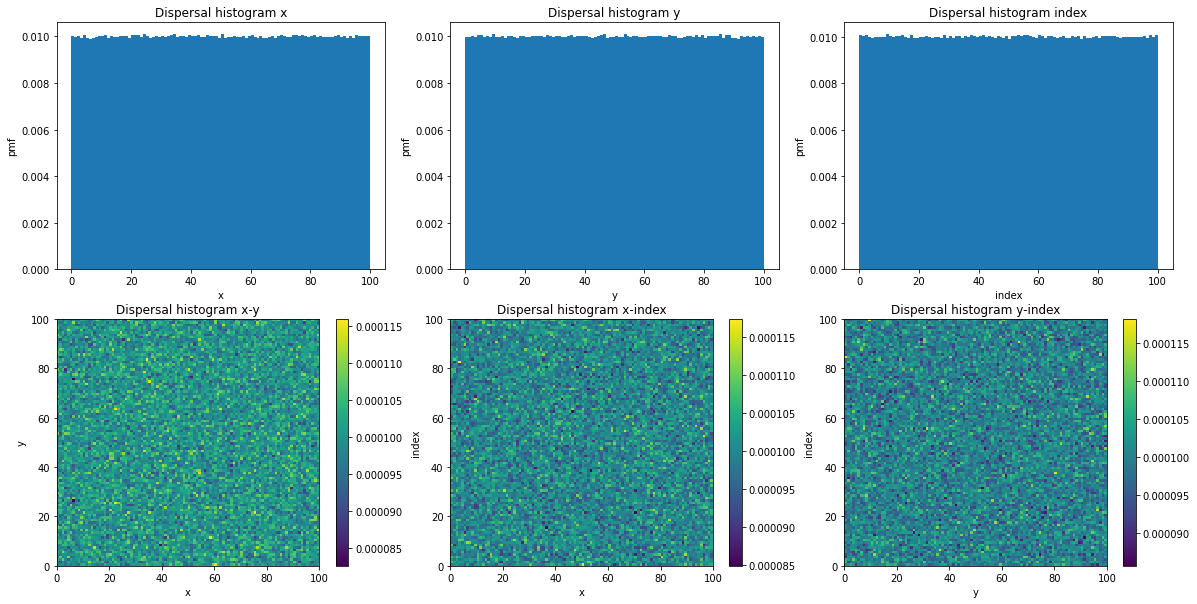

#### Configuration:
```rust
(speciation:1e-06,seed:123456789,sample:0.0001,algorithm:Classical(),scenario:NonSpatial(area:(100,100),deme:100),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

## <span style='color:green'>Gillespie</span>

#### Chi-squared test:
* p-value: {gof.pvalue}
* statistic: {gof.statistic}

#### Coverage Histograms:

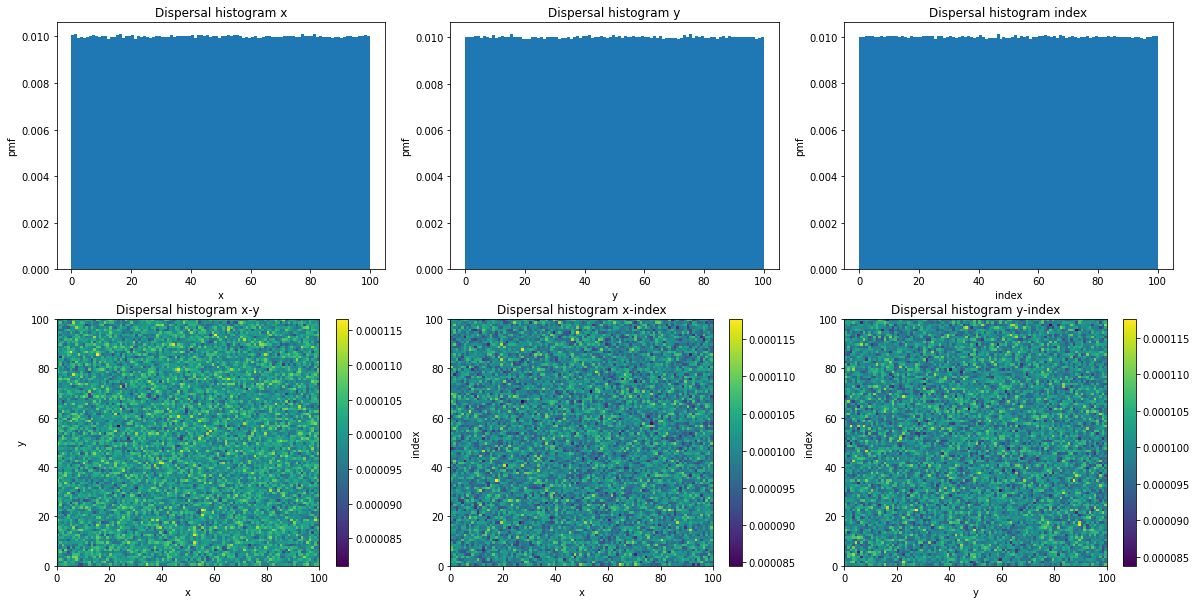

#### Configuration:
```rust
(speciation:1e-06,seed:123456789,sample:0.0001,algorithm:Gillespie(),scenario:NonSpatial(area:(100,100),deme:100),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

## <span style='color:green'>SkippingGillespie</span>

#### Chi-squared test:
* p-value: {gof.pvalue}
* statistic: {gof.statistic}

#### Coverage Histograms:

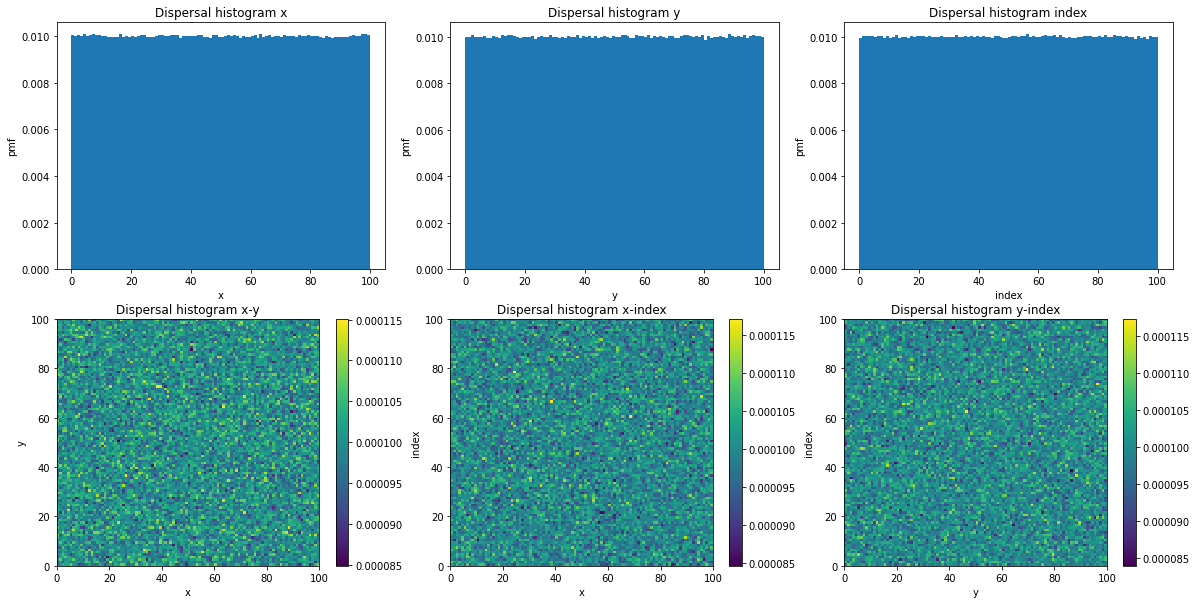

#### Configuration:
```rust
(speciation:1e-06,seed:123456789,sample:0.0001,algorithm:SkippingGillespie(),scenario:NonSpatial(area:(100,100),deme:100),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

## <span style='color:green'>Independent</span>

#### Chi-squared test:
* p-value: {gof.pvalue}
* statistic: {gof.statistic}

#### Coverage Histograms:

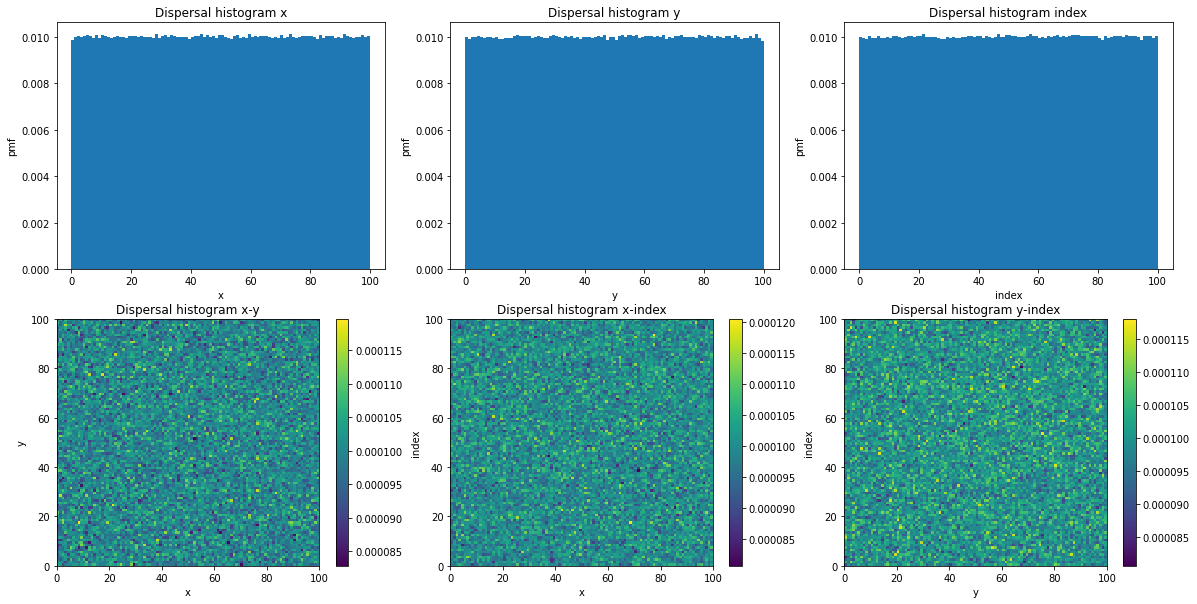

#### Configuration:
```rust
(speciation:1e-06,seed:123456789,sample:0.0001,algorithm:Independent(),scenario:NonSpatial(area:(100,100),deme:100),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

In [4]:
for algorithm in ["Classical", "Gillespie", "SkippingGillespie", "Independent"]:
    test_nonspatial_dispersal_coverage(
        algorithm, size=100, seed=123456789, sample=0.0001, speciation=0.000001
    )

# Normal Dispersal Kernel Test

In [5]:
def test_normal_dispersal_kernel(
    algorithm, speciation=0.001, seed=42, sample=1.0, radius=0, sigma=100.0,
):
    # Configure the simulation
    config = "".join("""
    (
        speciation: {speciation},
        seed: {seed},
        sample: {sample},

        algorithm: {algorithm}(),

        scenario: AlmostInfinite(
            radius: {radius},
            sigma: {sigma},
        ),

        reporters: [
            Plugin(
                library: "{target_directory}/release/deps/libnecsim_plugins_statistics.so",
                reporters: [
                    GlobalCoverage(output: "{output_file}"),
                ],
            ),
        ],
    )
    """.format(
        target_directory=target_directory, output_file="/dev/fd/2",
        algorithm=algorithm, speciation=speciation, seed=seed, sample=sample,
        radius=radius, sigma=sigma,
    ).split()).replace(",)", ")").replace(",]", "]")
    
    # Run the simulation
    locations_io = StringIO(subprocess.run(shlex.split(
        "cargo run --release --features rustcoalescence-algorithms-monolithic,"
        + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
    ), check=True, capture_output=True, text=True).stderr)

    # Read in the dispersal locations
    location_deltas = []
    with locations_io:
        reader = csv.reader(locations_io)
        next(reader)

        for row in reader:
            location_deltas.append((int(row[3]) - int(row[0]), int(row[4]) - int(row[1])))
    location_deltas = np.array(location_deltas)
    
    np.random.seed(seed)
    samples = np.round(np.random.normal(loc=0.0, scale=sigma, size=(len(location_deltas), 2)))
    
    gof_x = kstest(location_deltas[:,0], samples[:,0])
    gof_y = kstest(location_deltas[:,1], samples[:,1])
    
    if gof_x.pvalue <= 0.05 or gof_y.pvalue <= 0.05:
        display(Markdown(f"## <span style='color:red'><u>{algorithm}</u></span>"))
    elif gof_x.pvalue <= 0.1 or gof_y.pvalue <= 0.1:
        display(Markdown(f"## <span style='color:orange'>*{algorithm}*</span>"))
    else:
        display(Markdown(f"## <span style='color:green'>{algorithm}</span>"))
        
    display(Markdown("#### Chi-squared test:"))
    display(Markdown(f"* x-axis p-value: {gof_x.pvalue}\n* x-axis statistic: {gof_x.statistic}"))
    display(Markdown(f"* y-axis p-value: {gof_y.pvalue}\n* y-axis statistic: {gof_y.statistic}"))
    
    display(Markdown("#### Coverage Histograms:"))
    
    sigma_3 = int(3*sigma)
    step = int(max(sigma_3*2 / 100, 1))
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    
    ax1.set_title("Per-generation relative dispersal")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    hist1 = ax1.hist2d(location_deltas[:,0], location_deltas[:,1], bins=(range(-sigma_3, sigma_3+1, step), range(-sigma_3, sigma_3+1, step)), density=True)
    fig.colorbar(hist1[3], ax=ax1)
    
    x = np.linspace(-sigma_3, sigma_3, 2*sigma_3 + 1)
    p = norm.pdf(x, loc=0.0, scale=sigma)
    
    ax2.set_title("Dispersal histogram x")
    ax2.set_xlabel("x")
    ax2.set_ylabel("pmf")
    ax2.plot(x, p, color='red', linewidth=2, alpha=0.5, label=f"expected: mu=0.0 sigma={sigma}")
    loc, scale = norm.fit(location_deltas[:,0])
    ax2.hist(location_deltas[:,0], bins=range(-sigma_3, sigma_3+1), density=True, label=f"observed: mu≈{round(loc, 3)} sigma≈{round(scale, 3)}")
    ax2.legend()
    ax2.legend(loc='lower center')
    
    ax3.set_title("Dispersal histogram y")
    ax3.set_xlabel("y")
    ax3.set_ylabel("pmf")
    ax3.plot(x, p, color='red', linewidth=2, alpha=0.5, label=f"expected: mu=0.0 sigma={sigma}")
    loc, scale = norm.fit(location_deltas[:,1])
    ax3.hist(location_deltas[:,1], bins=range(-sigma_3, sigma_3+1), density=True, label=f"observed: mu≈{round(loc, 3)} sigma≈{round(scale, 3)}")
    ax3.legend(loc='lower center')
    
    plt.show()
    
    display(Markdown(f"#### Configuration:\n```rust\n{config}\n```"))

## <span style='color:green'>Classical</span>

#### Chi-squared test:

* x-axis p-value: 0.33681256713218743
* x-axis statistic: 0.0010153468898688178

* y-axis p-value: 0.827778751022701
* y-axis statistic: 0.0006745758067625562

#### Coverage Histograms:

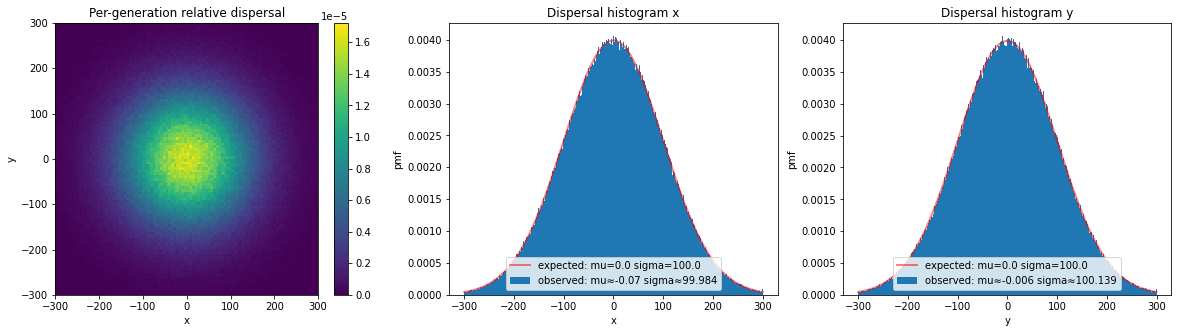

#### Configuration:
```rust
(speciation:0.001,seed:123456789,sample:1.0,algorithm:Classical(),scenario:AlmostInfinite(radius:25,sigma:100.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

## <span style='color:green'>Gillespie</span>

#### Chi-squared test:

* x-axis p-value: 0.6393941864002901
* x-axis statistic: 0.0008114740883605753

* y-axis p-value: 0.8323274376838277
* y-axis statistic: 0.0006807067407880174

#### Coverage Histograms:

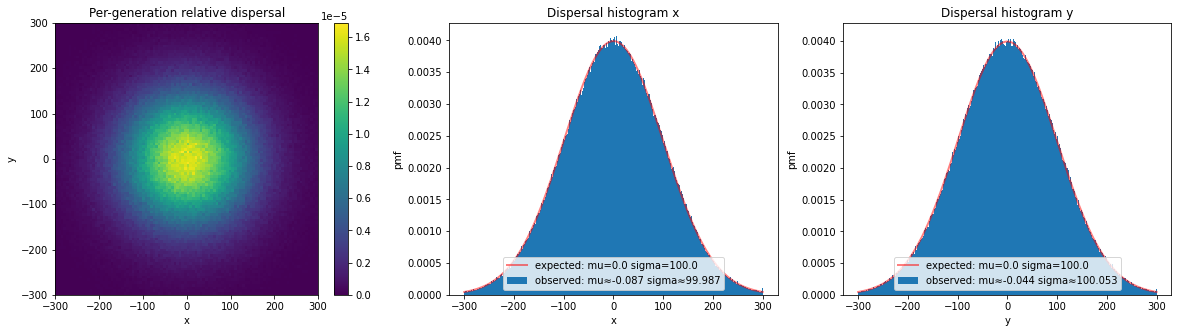

#### Configuration:
```rust
(speciation:0.001,seed:123456789,sample:1.0,algorithm:Gillespie(),scenario:AlmostInfinite(radius:25,sigma:100.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

## <span style='color:green'>SkippingGillespie</span>

#### Chi-squared test:

* x-axis p-value: 0.6378880805444573
* x-axis statistic: 0.0008010550707946984

* y-axis p-value: 0.4913960556305067
* y-axis statistic: 0.0008974138691656419

#### Coverage Histograms:

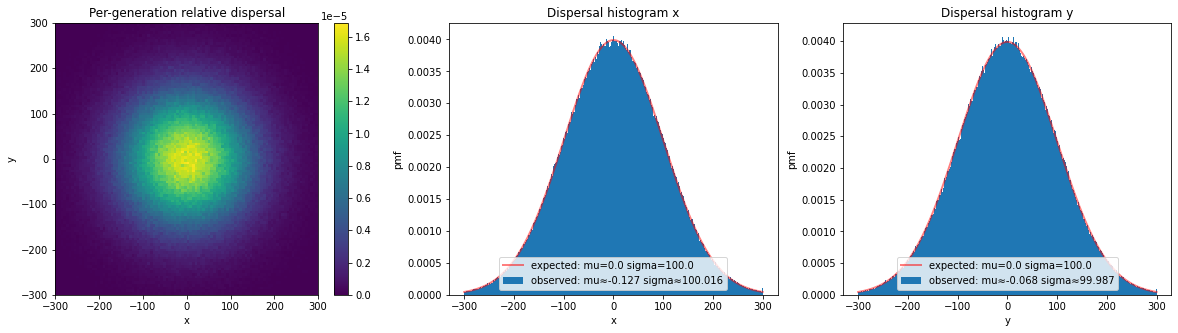

#### Configuration:
```rust
(speciation:0.001,seed:123456789,sample:1.0,algorithm:SkippingGillespie(),scenario:AlmostInfinite(radius:25,sigma:100.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

## <span style='color:green'>Independent</span>

#### Chi-squared test:

* x-axis p-value: 0.1554693911557613
* x-axis statistic: 0.0011992400119191782

* y-axis p-value: 0.6154675943387171
* y-axis statistic: 0.000803248594174133

#### Coverage Histograms:

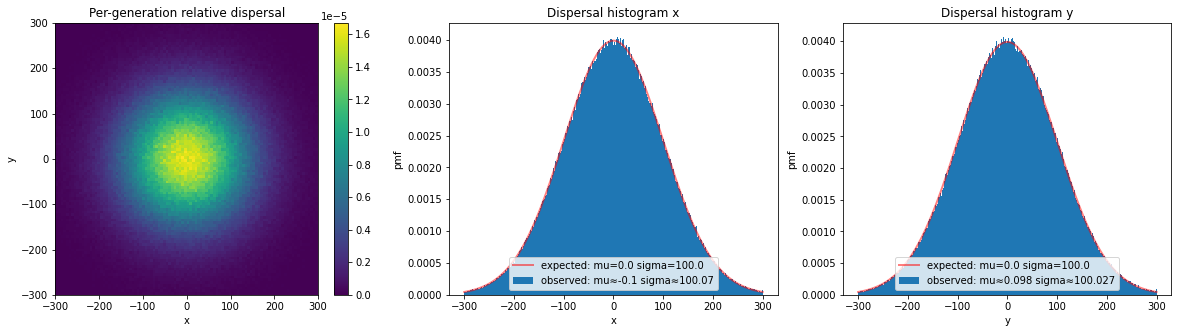

#### Configuration:
```rust
(speciation:0.001,seed:123456789,sample:1.0,algorithm:Independent(),scenario:AlmostInfinite(radius:25,sigma:100.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

In [6]:
for algorithm in ["Classical", "Gillespie", "SkippingGillespie", "Independent"]:
    test_normal_dispersal_kernel(
        algorithm, speciation=0.001, seed=123456789, sample=1.0, radius=25, sigma=100.0
    )